In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from scipy.signal import butter, lfilter
import seaborn as sns

In [2]:
sns.set()

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    """ This function implements a Butterworth bandpass filter """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def data_fft(data,Fs=26):
    """ Apply a fast-Fourier-transform to the dataframe. 26 Hz is the sampling frequency of our sensors. """
    Fs = 26;  # sampling rate
    Ts = 1.0/Fs; # sampling interval
    n = len(data) # length of the signal
    k = np.arange(n)
    T = round(n/Fs)
    frq = k/T # two sides frequency range
    frq = frq[range(round(n/2))] # one side frequency range
    t = np.arange(0,n*Ts,Ts)
    Y = np.fft.fft(data)/n # fft computing and normalization
    Y = Y[range(round(n/2))]
    return frq, abs(Y)

# Sequence of fiter and then FFT

def data_process(data, lowcut=3, highcut=8, fs=26,order=5): 
    """ Combination of bandpass and fft. 
        The deafault values for lowcut and highcut reflec the window of parkinson's tremors """
    data = butter_bandpass_filter(data, lowcut, highcut, fs, order)
    freq, intensity = data_fft(data,fs) # frequency vs intensity for plotting
    return freq, intensity

# The sensor data comes in several log files, here we merge them all and turn them into a dataframe.
# if parameter name is given (string), it exports the file to a .csv

def read_in_data_TXT(path, export_path=None):  
    """ Concatenates many .txt log files and returns a pandas DataFrame.
    If export_path is given inluding also the name of the file, it exports it as a .csv file."""
    
    files = glob.glob(path + "/*.TXT")
    frame = pd.DataFrame()
    
 
    df_list = [pd.read_table(file_, delimiter=',', names=['time','acc_X','acc_Y','acc_Z','gyro_X','gyro_Y','gyro_Z','heading']) for file_ in files]
    
    frame = pd.concat(df_list,ignore_index=True)
    
    if export_path:
        try:
            frame.to_csv(export_path + '.csv')
        except:
            raise TypeError("Incorrect name to export, no csv exported")         
    
    return frame    

## Read raw data into DataFrames

In [4]:
kitti_day_1 = read_in_data_TXT('RawData/Tremor/KittiDay1')
kitti_day_2 = read_in_data_TXT('RawData/Tremor/KittiDay2')

kitti_tapping = read_in_data_TXT('RawData/TappingExercise/Kitti')

lars_day_1 = read_in_data_TXT('RawData/Tremor/LarsDay1')
lars_day_2 = read_in_data_TXT('RawData/Tremor/LarsDay2')

lars_tapping_affected_hand = read_in_data_TXT('RawData/TappingExercise/Lars_affected_hand')
lars_tapping_good_hand = read_in_data_TXT('RawData/TappingExercise/Lars_good_hand')

## Tremor analysis - the data from the gyroscope is the most distinguishing
### Day 1 -- Process data with the bandpass filter

In [5]:
kitti_gyro_X = kitti_day_1['gyro_X'].values
kitti_gyro_Y = kitti_day_1['gyro_Y'].values
kitti_gyro_Z = kitti_day_1['gyro_Z'].values

kgx1, kgx2 = data_process(kitti_gyro_X)
kgy1, kgy2 = data_process(kitti_gyro_Y)
kgz1, kgz2 = data_process(kitti_gyro_Z)

In [6]:
lars_gyro_X = lars_day_1['gyro_X'].values
lars_gyro_Y = lars_day_1['gyro_Y'].values
lars_gyro_Z = lars_day_1['gyro_Z'].values


lgx1, lgx2 = data_process(lars_gyro_X)
lgy1, lgy2 = data_process(lars_gyro_Y)
lgz1, lgz2 = data_process(lars_gyro_Z)

## In the spectrogram, Lars' data (positive) has dark red marks around 5Hz and Kitti's (negative) doesn't

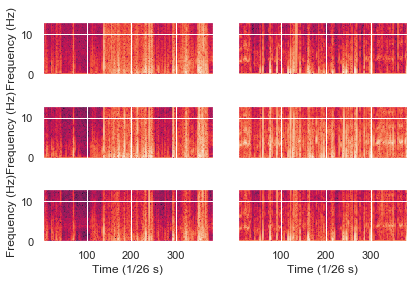

In [7]:
f, ((kX, lX),(kY,lY),(kZ, lZ)) = plt.subplots(3,2,sharex=True,sharey=True)


kX.specgram(kitti_day_1['gyro_X'].values[10000:20000], NFFT=150,   Fs=26, noverlap=128);
kY.specgram(kitti_day_1['gyro_Y'].values[10000:20000], NFFT=150,   Fs=26, noverlap=128);
kZ.specgram(kitti_day_1['gyro_Z'].values[10000:20000], NFFT=150,   Fs=26, noverlap=128);
kX.set_ylim(3,8)
kY.set_ylim(3,8)
kZ.set_ylim(3,8)

lX.set_ylim(3,8)
lY.set_ylim(3,8)
lZ.set_ylim(3,8)


kX.set_ylabel('Frequency (Hz)')
kY.set_ylabel('Frequency (Hz)')
kZ.set_ylabel('Frequency (Hz)')

kZ.set_xlabel('Time (1/26 s)')
lZ.set_xlabel('Time (1/26 s)')

lX.specgram(lars_day_1['gyro_X'].values[10000:20000], NFFT=150,   Fs=26, noverlap=128);
lY.specgram(lars_day_1['gyro_Y'].values[10000:20000], NFFT=150,   Fs=26, noverlap=128);
lZ.specgram(lars_day_1['gyro_Z'].values[10000:20000], NFFT=150,   Fs=26, noverlap=128);

f.tight_layout()


## Fourier transform of the gyroscope data 

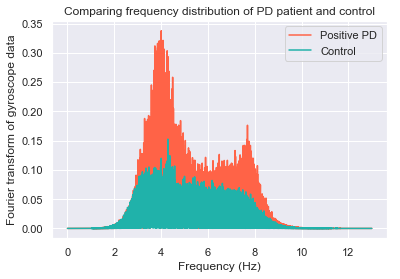

In [8]:
%matplotlib inline

x1, y1 = data_process(lars_gyro_Y)
x2, y2 = data_process(kitti_gyro_Y)
lars, = plt.plot(x1,y1,'tomato',label='Positive PD')
kitti, = plt.plot(x2,y2,'lightseagreen',label='Control')
plt.legend(handles=[lars,kitti])
plt.title("Comparing frequency distribution of PD patient and control")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Fourier transform of gyroscope data')
plt.savefig('Plots/freq_plot.svg', format = 'svg', quality=95)
plt.show()

## Comparison between gyroscope data in 3 directions for negative and positive subjects

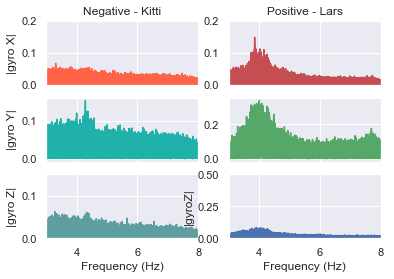

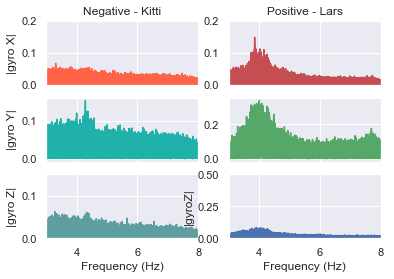

In [9]:
f, ((kX, lX),(kY,lY),(kZ, lZ)) = plt.subplots(3,2,sharex=True)

kX.plot(kgx1,kgx2,'tomato')
kY.plot(kgy1,kgy2,'lightseagreen')
kZ.plot(kgz1,kgz2,'cadetblue')

kX.set_ylabel('|gyro X|')
kX.set_yticks([0.0,0.1,0.2])
lX.set_yticks([0.0,0.1,0.2])

kX.set_title("Negative - Kitti")
kX.set_ylim(0,0.2)
kX.set_xlim(3,8)
lX.set_xlim(3,8)
lX.set_ylim(0,0.2)

kY.set_ylabel('|gyro Y|')
kZ.set_ylabel('|gyro Z|')


kZ.set_ylim(0,0.15)
kZ.set_xlabel('Frequency (Hz)')

lX.set_title("Positive - Lars")

lX.plot(lgx1,lgx2,'r')
lY.plot(lgy1,lgy2,'g')
lZ.plot(lgz1,lgz2,'b')
lZ.set_ylim(0,0.5)
lZ.set_xlabel('Frequency (Hz)')
lZ.set_ylabel('|gyroZ|')


f